In [17]:
import json 
import re
from typing import Dict, Any
import pandas as pd
import os
# Import your libs
from schema_matcher_lib import SchemaMatcher
from camera_entity_lib import CameraEntityResolver
from imputation_lib import ImputationConfig, DataImputationEngine
import torch

import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report


from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

In [11]:
df = pd.read_csv("schema_matching_labeled.csv")

In [9]:
len(df['target_attribute_name'].value_counts())

56

In [32]:
df_schema_sample = df.sample(n=500, random_state=42)


In [96]:
df_schema_sample.head() 

,site,record_id,attr,value,target_property,difficulty,target_norm,pred_zero_norm,pred_ft_norm
39918,www.ebay.com,44064,optical zoom,5x,zoom_optical,A,zoom optical,auto focus points,zoom optical
91806,www.pcconnection.com,12439,color,Black,color,A,color,color,color
60292,www.ebay.com,54875,screen size,"3""",screen_size,A,screen size,auto focus points,screen size
10415,www.alibaba.com,28249,lens mount,φ14,lens_mount_type,A,lens mount type,auto focus mode,lens mount type
104999,www.priceme.co.nz,2299,max image resolution,4608x3456,image_resolution_lw,A,image resolution lw,auto focus points,image resolution


In [34]:
MODEL_NAME = "Qwen/Qwen2-0.5B-Instruct"
ADAPTER_DIR = "qwen0.5-schema-matching-lora_latest"

# Canonical fields
df_fields = pd.read_csv("canonical_fields.csv")
CANONICAL_FIELDS = df_fields["canonical_property"].tolist()

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token


def build_messages(site: str, attr: str, value: str):
    user_prompt = f"""You are given one attribute from a product specification record.
Your task is to identify which canonical property it belongs to.

Information:
- Source website: {site}
- attribute name: {attr}
- attribute value: {value}

Choose exactly one canonical property from the list below:
{chr(10).join(CANONICAL_FIELDS)}

Respond with only the canonical property name and nothing else."""
    
    messages = [
        {
            "role": "system",
            "content": "You are a schema-matching assistant. Map attributes to canonical properties.",
        },
        {
            "role": "user",
            "content": user_prompt,
        },
    ]
    return messages


def build_prompt(site: str, attr: str, value: str) -> str:
    messages = build_messages(site, attr, value)
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )
    return prompt

In [35]:
@torch.inference_mode()
def predict_property_with_model(
    model,
    site: str,
    attr: str,
    value: str,
    max_new_tokens: int = 8,
) -> str:
    prompt = build_prompt(site, attr, value)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,          # greedy, deterministic
        temperature=0.0,
        pad_token_id=tokenizer.eos_token_id,
    )

    # only the generated part
    gen_tokens = outputs[0][inputs["input_ids"].shape[1]:]
    text = tokenizer.decode(gen_tokens, skip_special_tokens=True)

    canonical = text.strip().splitlines()[0].strip()

    # if canonical not in CANONICAL_FIELDS:
    #     print(f"[WARN] Predicted '{canonical}' not in canonical list.")
    return canonical 

In [36]:
# ----- Base model for zero-shot -----
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="cuda",
)
base_model.eval()

# ----- Fine-tuned model (LoRA adapter on top of same base) -----
ft_base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="cuda",
)
ft_model = PeftModel.from_pretrained(ft_base_model, ADAPTER_DIR).to("cuda")
ft_model.eval()

# small wrappers for clarity
def predict_zero_shot(site: str, attr: str, value: str) -> str:
    return predict_property_with_model(base_model, site, attr, value)

def predict_finetuned(site: str, attr: str, value: str) -> str:
    return predict_property_with_model(ft_model, site, attr, value)

In [65]:
def normalize_label(label: str) -> str:
    """
    Normalize labels so that small formatting differences
    (underscore, hyphen, extra spaces) don't matter.
    """
    if not isinstance(label, str):
        return ""
    label = label.lower()
    # replace underscores / hyphens / slashes with space
    label = re.sub(r"[_\-\/]", " ", label)
    # collapse multiple spaces
    label = re.sub(r"\s+", " ", label).strip()
    return label


def evaluate_on_dataframe(df: pd.DataFrame, predictor_fn, desc: str = ""):
    """
    df must contain: 'site', 'attr', 'value', 'target_property'
    predictor_fn: function(site, attr, value) -> predicted canonical property (raw string)
    We evaluate on NORMALIZED labels (semantic match, not exact string).
    """
    y_true_norm = []
    y_pred_norm = []

    # (optional) keep raw for inspection
    y_true_raw = []
    y_pred_raw = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Evaluating {desc}"):
        site = row["site"]
        attr = row["attr"]
        value = row["value"]
        target = row["target_property"]

        pred = predictor_fn(site, attr, value)

        # raw
        y_true_raw.append(target)
        y_pred_raw.append(pred)

        # normalized
        y_true_norm.append(normalize_label(target))
        y_pred_norm.append(normalize_label(pred))

    # metrics on normalized labels
    acc = accuracy_score(y_true_norm, y_pred_norm)
    macro_f1 = f1_score(y_true_norm, y_pred_norm, average="macro")
    weighted_f1 = f1_score(y_true_norm, y_pred_norm, average="weighted")

    print("=" * 80)
    print(f"Evaluation: {desc}")
    print(f"Accuracy     : {acc:.4f}")
    print(f"Macro F1     : {macro_f1:.4f}")
    print(f"Weighted F1  : {weighted_f1:.4f}")
    print("\nClassification report (normalized labels):")
    print(classification_report(y_true_norm, y_pred_norm, digits=4))
    print("=" * 80)

    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "y_true_raw": y_true_raw,
        "y_pred_raw": y_pred_raw,
        "y_true_norm": y_true_norm,
        "y_pred_norm": y_pred_norm,
    }

In [66]:
# tokenization helper
def tokenize(text):
    return re.findall(r"[a-zA-Z0-9]+", text.lower())

def assign_bucket(attr, target):
    attr_tokens = set(tokenize(attr))
    target_tokens = set(tokenize(target))
    
    # ---------- Bucket A: high overlap ----------
    overlap = attr_tokens.intersection(target_tokens)
    if len(overlap) > 0:
        return "A"
    
    # ---------- Bucket B: synonyms/paraphrase ----------
    SYNONYMS = {
        "screen_size": ["display", "lcd", "diagonal"],
        "image_resolution": ["megapixel", "mp", "pixels", "resolution"],
        "sensor_type": ["cmos", "ccd", "bsi"],
        "camera_depth": ["depth", "dimension"],
        "lens_mount_type": ["mount", "lens type"],
        "zoom_optical": ["optical zoom"],
        "zoom_digital": ["digital zoom"],
    }
    
    for canon, words in SYNONYMS.items():
        if target == canon:
            for w in words:
                if w in attr.lower():
                    return "B"
    
    # ---------- Bucket C: noisy ----------
    return "C"


df_schema_sample["difficulty"] = df_schema_sample.apply(lambda row: assign_bucket(row["attr"], row["target_property"]), axis=1)
df_schema_sample.head()

,site,record_id,attr,value,target_property,difficulty,target_norm,pred_zero_norm,pred_ft_norm
39918,www.ebay.com,44064,optical zoom,5x,zoom_optical,A,zoom optical,auto focus points,zoom optical
91806,www.pcconnection.com,12439,color,Black,color,A,color,color,color
60292,www.ebay.com,54875,screen size,"3""",screen_size,A,screen size,auto focus points,screen size
10415,www.alibaba.com,28249,lens mount,φ14,lens_mount_type,A,lens mount type,auto focus mode,lens mount type
104999,www.priceme.co.nz,2299,max image resolution,4608x3456,image_resolution_lw,A,image resolution lw,auto focus points,image resolution


In [67]:
df_schema_sample

,site,record_id,attr,value,target_property,difficulty,target_norm,pred_zero_norm,pred_ft_norm
39918,www.ebay.com,44064,optical zoom,5x,zoom_optical,A,zoom optical,auto focus points,zoom optical
91806,www.pcconnection.com,12439,color,Black,color,A,color,color,color
60292,www.ebay.com,54875,screen size,"3""",screen_size,A,screen size,auto focus points,screen size
10415,www.alibaba.com,28249,lens mount,φ14,lens_mount_type,A,lens mount type,auto focus mode,lens mount type
104999,www.priceme.co.nz,2299,max image resolution,4608x3456,image_resolution_lw,A,image resolution lw,auto focus points,image resolution
...,...,...,...,...,...,...,...,...,...
101869,www.pricedekho.com,1259,minimum shutter speed,"Night : 1/8 - 1/500 sec, Night (Tripod) : 3 se...",shutter_speed_min,A,shutter speed min,auto focus mode,shutter speed min
53599,www.ebay.com,48986,megapixels,12.0 MP,image_resolution,B,image resolution,auto focus mode,image resolution
80888,www.gosale.com,751,redeye reduction,Yes,red_eye_reduction,A,red eye reduction,auto focus points,red eye reduction
26711,www.cambuy.com.au,40,autofocus af,Contrast-detect AF,auto_focus_type,C,auto focus type,auto focus mode,auto focus type


In [54]:
# df_schema_sample = pd.read_csv("df_schema_sample.csv")  # or however you saved it

In [73]:
# zero-shot baseline
results_zero = evaluate_on_dataframe(
    df_schema_sample,
    predictor_fn=predict_zero_shot,
    desc="Qwen base (zero-shot)"
) 

Evaluating Qwen base (zero-shot): 100%|██████████████████████████████████████████████| 500/500 [01:37<00:00,  5.13it/s]

Evaluation: Qwen base (zero-shot)
Accuracy     : 0.1560
Macro F1     : 0.0653
Weighted F1  : 0.1688

Classification report (normalized labels):
                                precision    recall  f1-score   support

                 audio formats     0.0000    0.0000    0.0000         0
               auto focus auto     0.0000    0.0000    0.0000         0
          auto focus automatic     0.0000    0.0000    0.0000         6
               auto focus beam     1.0000    0.3333    0.5000         3
               auto focus mode     0.0000    0.0000    0.0000         1
             auto focus points     0.0357    1.0000    0.0690         3
               auto focus type     0.0000    0.0000    0.0000         1
               auto focus zoom     0.0000    0.0000    0.0000         0
             battery chemistry     1.0000    1.0000    1.0000         1
                         brand     1.0000    0.8451    0.9160        71
                builtin memory     0.0000    0.0000    0.0000  


C:\Users\Arpita\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Arpita\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Arpita\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Us

In [70]:
# fine-tuned model
results_ft = evaluate_on_dataframe(
    df_schema_sample,
    predictor_fn=predict_finetuned,
    desc="Qwen fine-tuned (LoRA)"
)

Evaluating Qwen fine-tuned (LoRA): 100%|█████████████████████████████████████████████| 500/500 [02:17<00:00,  3.64it/s]

Evaluation: Qwen fine-tuned (LoRA)
Accuracy     : 0.8700
Macro F1     : 0.6846
Weighted F1  : 0.8758

Classification report (normalized labels):
                              precision    recall  f1-score   support

        auto focus automatic     1.0000    1.0000    1.0000         6
             auto focus beam     1.0000    1.0000    1.0000         3
             auto focus mode     0.0000    0.0000    0.0000         1
           auto focus points     0.6667    0.6667    0.6667         3
             auto focus type     1.0000    1.0000    1.0000         1
           battery chemistry     1.0000    1.0000    1.0000         1
                       brand     1.0000    0.8169    0.8992        71
                camera depth     0.6667    1.0000    0.8000         6
               camera height     1.0000    1.0000    1.0000         1
                 camera type     0.5385    1.0000    0.7000         7
                camera width     0.0000    0.0000    0.0000         6
              


C:\Users\Arpita\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Arpita\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Arpita\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Us

In [80]:
results_zero_bucket = df_schema_sample.groupby("difficulty").apply(
    lambda x: (x["pred_zero_norm"] == x["target_norm"]).mean()
)

results_ft_bucket = df_schema_sample.groupby("difficulty").apply(
    lambda x: (x["pred_ft_norm"] == x["target_norm"]).mean()
)

C:\Users\Arpita\AppData\Local\Temp\ipykernel_10744\4246874502.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_zero_bucket = df_schema_sample.groupby("difficulty").apply(
C:\Users\Arpita\AppData\Local\Temp\ipykernel_10744\4246874502.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_ft_bucket = df_schema_sample.groupby("difficulty").apply(


In [81]:
# # normalized gold labels
# df_schema_sample["target_norm"] = results_zero["y_true_norm"]

# # zero-shot predictions
# df_schema_sample["pred_zero_norm"] = results_zero["y_pred_norm"]

# # fine-tuned predictions
# df_schema_sample["pred_ft_norm"] = results_ft["y_pred_norm"]

In [82]:
bucket_desc = {
    "A": "high token overlap",
    "B": "synonym/paraphrase",
    "C": "noisy/ambiguous"
}

bucket_table = pd.DataFrame({
    "Bucket": results_zero_bucket.index,
    "Description": results_zero_bucket.index.map(bucket_desc),
    "Zero-shot Acc": results_zero_bucket.values,
    "Fine-tuned Acc": results_ft_bucket.values,
})

bucket_table

,Bucket,Description,Zero-shot Acc,Fine-tuned Acc
0,A,high token overlap,0.204724,0.889764
1,B,synonym/paraphrase,0.000000,0.936709
2,C,noisy/ambiguous,0.000000,0.550000


In [111]:
df_schema_sample[df_schema_sample['difficulty']=='C'].head(30)

,site,record_id,attr,value,target_property,difficulty,target_norm,pred_zero_norm,pred_ft_norm
28367,www.canon-europe.com,157,redeye correction,"Yes, during shooting and playback",red_eye_reduction,C,red eye reduction,auto focus mode,picture styles
15566,www.buzzillions.com,1817,pixel count,8 Megapixel,image_resolution,C,image resolution,auto focus points,image resolution
81097,www.gosale.com,860,manufacturer,Sony,brand,C,brand,manufacturer,camera width
84043,www.ilgs.net,125,display,TFT,screen_type,C,screen type,auto focus points,image resolution
81201,www.gosale.com,919,manufacturer,Canon,brand,C,brand,manufacturer,camera type
20713,www.buzzillions.com,2480,pixel count,10 Megapixel,image_resolution,C,image resolution,auto focus points,image resolution
28995,www.canon-europe.com,75,photo effects,"Vivid, Neutral, Low Sharpening, Sepia, Black &...",picture_styles,C,picture styles,auto focus mode,picture styles
79705,www.gosale.com,1216,manufacturer,Panasonic,brand,C,brand,manufacturer,camera width
11265,www.alibaba.com,29563,frame rate,"50Hz: 20fps (2048 x 1536), 25fps (1920 × 1080)...",video_resolution,C,video resolution,auto focus mode,video resolution
8230,www.alibaba.com,24919,frame rate,"50Hz: 20fps (2048 × 1536), 25fps (1920 × 1080)...",video_resolution,C,video resolution,auto focus mode,video resolution


In [84]:
df_schema_sample.to_csv("schema-results.csv",index=False)

In [94]:
def plot_bucket_accuracy_by_model(bucket_table, title="Accuracy Breakdown by Model and Difficulty"):
    """
    bucket_table must contain:
    'Bucket', 'Description', 'Zero-shot Acc', 'Fine-tuned Acc'
    """

    # X-axis categories
    x_labels = ["Zero-shot", "Fine-tuned"]
    x = np.arange(len(x_labels))
    width = 0.25

    # Extract bucket-level data
    buckets = bucket_table["Bucket"].tolist()
    descs   = bucket_table["Description"].tolist()
    zero    = bucket_table["Zero-shot Acc"].values
    ft      = bucket_table["Fine-tuned Acc"].values

    fig, ax = plt.subplots(figsize=(10, 5))

    # Loop over difficulty buckets
    for i, (bucket, desc) in enumerate(zip(buckets, descs)):
        ax.bar(
            x + (i - 1) * width,      # shift bars relative to center
            [zero[i], ft[i]],
            width,
            label=desc,               # legend uses the full description
            alpha=0.85
        )

    # Axes formatting
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_ylim(0, 1.05)

    ax.legend(title="Difficulty Level", fontsize=10, title_fontsize=11)

    # Add accuracy numbers above bars
    for i, desc in enumerate(descs):
        for j, acc in enumerate([zero[i], ft[i]]):
            ax.text(
                x[j] + (i - 1) * width,
                acc + 0.02,
                f"{acc:.2f}",
                ha="center",
                fontsize=10
            )

    plt.tight_layout()
    plt.savefig("bucket_accuracy_chart.png", dpi=300) 
    plt.show()

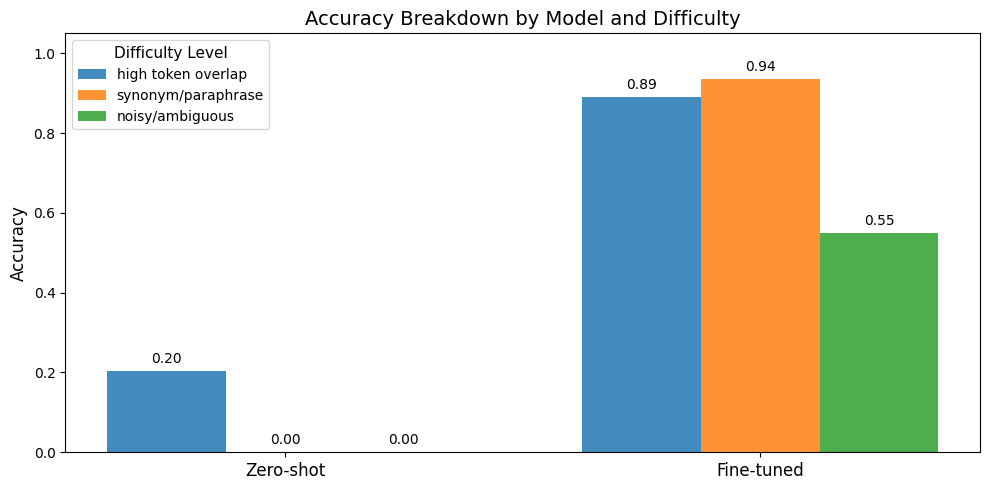

In [95]:
plot_bucket_accuracy_by_model(bucket_table)


In [93]:
plt.savefig("bucket_accuracy_chart.png", dpi=300) 

<Figure size 640x480 with 0 Axes>